# Dependency code

In [1]:
import imp
import os
import sys
import numpy as np
import glob
import cmdbench

fp, pathname, description = imp.find_module('benchmark', ['../lib'])
benchmark = imp.load_module('benchmark', fp, pathname, description)

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

# Software versions

In [2]:
!mash --version

2.2.2


# Benchmarking

## Input data and constants

In [3]:
input_dir = 'input'
input_files_1 = [os.path.basename(f) for f in glob.glob(f'{input_dir}/*_1.fastq.gz')]
input_samples = [f.replace('_1.fastq.gz','') for f in input_files_1]
input_samples.sort()
print(input_samples)

nproc=4
kmer=31
sketch_size=1000

mash_dir = 'mash-data'

sample_sizes = [1,10,20,30,40,50,60,70,80]

benchmark.create_folder_if_doesnt_exist(mash_dir)

['2014C-3598', '2014C-3599', '2014C-3600', '2014C-3655', '2014C-3656', '2014C-3840', '2014C-3850', '2014C-3857', '2014C-3907', '2014D-0067', '2014D-0068', '2014D-0070', '2014D-0189', 'CFSAN000189', 'CFSAN000191', 'CFSAN000211', 'CFSAN000212', 'CFSAN000228', 'CFSAN000661', 'CFSAN000669', 'CFSAN000700', 'CFSAN000752', 'CFSAN000753', 'CFSAN000951', 'CFSAN000952', 'CFSAN000954', 'CFSAN000958', 'CFSAN000960', 'CFSAN000961', 'CFSAN000963', 'CFSAN000968', 'CFSAN000970', 'CFSAN001112', 'CFSAN001115', 'CFSAN001118', 'CFSAN001140', 'CFSAN002349', 'CFSAN023463', 'CFSAN023464', 'CFSAN023465', 'CFSAN023466', 'CFSAN023467', 'CFSAN023468', 'CFSAN023469', 'CFSAN023470', 'CFSAN023471', 'D5663', 'D7316', 'D7319', 'D7320', 'D7321', 'D7322', 'D7323', 'D7324', 'D7327', 'D7328', 'D7329', 'D7330', 'D7331', 'D7333', 'D7334', 'MOD1_LS1000', 'MOD1_LS1003', 'MOD1_LS1004', 'MOD1_LS1005', 'MOD1_LS1006', 'MOD1_LS1008', 'MOD1_LS1009', 'MOD1_LS1010', 'MOD1_LS1011', 'MOD1_LS982', 'MOD1_LS985', 'MOD1_LS989', 'MOD1_LS99

## Benchmark functions

In [4]:
def reset_func():
    benchmark.clean_if_exists(mash_dir)
    
def sampling_func(sample_size):
    samples = input_samples[:sample_size]
    return samples
    
mash_command = {
    "command": f"mash sketch -r -p 1 -s {sketch_size} -k {kmer} -I % -o {mash_dir}/%.msh {input_dir}/%_1.fastq.gz {input_dir}/%_2.fastq.gz",
    "parallel_args": f"-j {nproc} -I%",
}

combine_sketchs_command = {
    "command": lambda inputs: f"mash paste {mash_dir}/sketches " + ' '.join([f"{mash_dir}/{x}.msh" for x in inputs]),
}

dist_calculation_times = 1
dist_calculating_genome = "2014C-3600_1.fastq.gz"

query_command = {
    "command": f"mash dist -p {nproc} {mash_dir}/sketches.msh {input_dir}/%",
    "parallel_args": "-j 1 -I%",
    "parallel_argfiles": [dist_calculating_genome] * dist_calculation_times
}

## Benchmark

In [5]:
multibench_results, debug_str = benchmark.multibench.multi_cmdbench({
        "index": [mash_command, combine_sketchs_command],
        "query": [query_command]
    },
    reset_func = reset_func, iterations = 1, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results=benchmark.benchmark_list_to_results, active_output_print = True
)

>>>>>>>>>>>>>
parallel -j 4 -I% mash sketch -r -p 1 -s 1000 -k 31 -I % -o mash-data/%.msh input/%_1.fastq.gz input/%_2.fastq.gz ::: 2014C-3598

STDOUT: 
-------------
STDERR: WARNING: The option p will be ignored with r.
Estimated genome size: 3.22011e+07
Estimated coverage:    6.456
Writing to mash-data/2014C-3598.msh...

<<<<<<<<<<<<<

>>>>>>>>>>>>>
mash paste mash-data/sketches mash-data/2014C-3598.msh

STDOUT: 
-------------
STDERR: Writing mash-data/sketches.msh...

<<<<<<<<<<<<<

>>>>>>>>>>>>>
parallel -j 1 -I% mash dist -p 4 mash-data/sketches.msh input/% ::: 2014C-3600_1.fastq.gz

STDOUT: 2014C-3598	input/2014C-3600_1.fastq.gz	0.0454931	0	139/1000

-------------
STDERR: 
<<<<<<<<<<<<<

>>>>>>>>>>>>>
parallel -j 4 -I% mash sketch -r -p 1 -s 1000 -k 31 -I % -o mash-data/%.msh input/%_1.fastq.gz input/%_2.fastq.gz ::: 2014C-3598 2014C-3599 2014C-3600 2014C-3655 2014C-3656 2014C-3840 2014C-3850 2014C-3857 2014C-3907 2014D-0067

STDOUT: 
-------------
STDERR: WARNING: The option p w

Process Process-24:
Traceback (most recent call last):
  File "/home/CSCScience.ca/apetkau/miniconda3/envs/thesis-benchmarking/lib/python3.8/site-packages/psutil/_common.py", line 449, in wrapper
    ret = self._cache[fun]
AttributeError: _cache

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/CSCScience.ca/apetkau/miniconda3/envs/thesis-benchmarking/lib/python3.8/site-packages/psutil/_pslinux.py", line 1515, in wrapper
    return fun(self, *args, **kwargs)
  File "/home/CSCScience.ca/apetkau/miniconda3/envs/thesis-benchmarking/lib/python3.8/site-packages/psutil/_common.py", line 452, in wrapper
    return fun(self)
  File "/home/CSCScience.ca/apetkau/miniconda3/envs/thesis-benchmarking/lib/python3.8/site-packages/psutil/_pslinux.py", line 1557, in _parse_stat_file
    with open_binary("%s/%s/stat" % (self._procfs_path, self.pid)) as f:
  File "/home/CSCScience.ca/apetkau/miniconda3/envs/thesis-benchmarking/lib/pytho

STDOUT: 
-------------
STDERR: Writing mash-data/sketches.msh...

<<<<<<<<<<<<<

>>>>>>>>>>>>>
parallel -j 1 -I% mash dist -p 4 mash-data/sketches.msh input/% ::: 2014C-3600_1.fastq.gz

STDOUT: 2014C-3598	input/2014C-3600_1.fastq.gz	0.0454931	0	139/1000
2014C-3599	input/2014C-3600_1.fastq.gz	0.0494529	0	121/1000
2014C-3600	input/2014C-3600_1.fastq.gz	0.0224566	0	332/1000
2014C-3655	input/2014C-3600_1.fastq.gz	0.0379938	0	182/1000
2014C-3656	input/2014C-3600_1.fastq.gz	0.0408582	0	164/1000
2014C-3840	input/2014C-3600_1.fastq.gz	0.0389111	0	176/1000
2014C-3850	input/2014C-3600_1.fastq.gz	0.038448	0	179/1000
2014C-3857	input/2014C-3600_1.fastq.gz	0.038448	0	179/1000
2014C-3907	input/2014C-3600_1.fastq.gz	0.0382957	0	180/1000
2014D-0067	input/2014C-3600_1.fastq.gz	0.200503	3.79597e-09	1/1000
2014D-0068	input/2014C-3600_1.fastq.gz	1	1	0/1000
2014D-0070	input/2014C-3600_1.fastq.gz	1	1	0/1000
2014D-0189	input/2014C-3600_1.fastq.gz	1	1	0/1000
CFSAN000189	input/2014C-3600_1.fastq.gz	0.200503	6.

# Save and reload results

In [6]:
save_path = "mash-results.txt"

samples_per_sample_size = []
for sample_size in sample_sizes:
        samples_per_sample_size.append(input_samples[:sample_size])

benchmark.multibench.save_multibench_results(multibench_results, samples_per_sample_size, save_path)
multibench_results, samples_per_sample_size = benchmark.multibench.read_multibench_results(save_path)

# Plot

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

[{'runtime': 12.61, 'memory': 31334400.0, 'disk_read': 182671918.0, 'disk_write': 782719.0}, {'runtime': 61.16, 'memory': 65511424.0, 'disk_read': 2676164001.0, 'disk_write': 1936373.0}, {'runtime': 100.3, 'memory': 65396736.0, 'disk_read': 5388727788.0, 'disk_write': 3275044.0}, {'runtime': 136.61, 'memory': 65531904.0, 'disk_read': 7731185066.0, 'disk_write': 4687425.0}, {'runtime': 176.5, 'memory': 65658880.0, 'disk_read': 9833255904.0, 'disk_write': 6083106.0}, {'runtime': 233.71, 'memory': 65601536.0, 'disk_read': 12581704434.0, 'disk_write': 7617940.0}, {'runtime': 347.24, 'memory': 65458176.0, 'disk_read': 18168520262.0, 'disk_write': 9431120.0}, {'runtime': 400.1, 'memory': 65777664.0, 'disk_read': 21537261730.0, 'disk_write': 10843089.0}, {'runtime': 462.8, 'memory': 65576960.0, 'disk_read': 25022574557.0, 'disk_write': 12328795.0}]


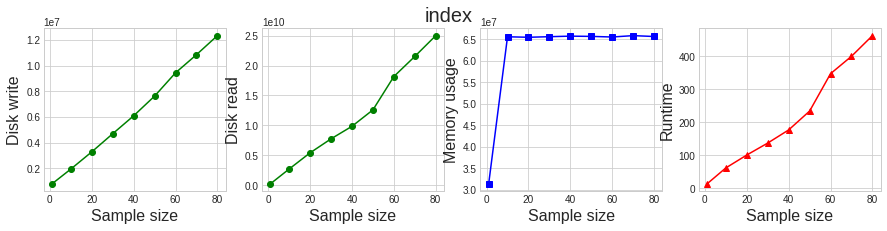

In [8]:
# Indexing Plots
benchmark.multibench.plot_resources(multibench_results, sample_sizes, "index")

[{'runtime': 18.13, 'memory': 31875072.0, 'disk_read': 238078102.0, 'disk_write': 811261.0}, {'runtime': 18.95, 'memory': 32092160.0, 'disk_read': 238078648.0, 'disk_write': 820544.0}, {'runtime': 17.67, 'memory': 32141312.0, 'disk_read': 238078156.0, 'disk_write': 813599.0}, {'runtime': 18.48, 'memory': 32313344.0, 'disk_read': 238079919.0, 'disk_write': 823082.0}, {'runtime': 18.15, 'memory': 32526336.0, 'disk_read': 238080549.0, 'disk_write': 816147.0}, {'runtime': 18.89, 'memory': 32616448.0, 'disk_read': 238081106.0, 'disk_write': 825452.0}, {'runtime': 17.84, 'memory': 33341440.0, 'disk_read': 238081641.0, 'disk_write': 818331.0}, {'runtime': 18.53, 'memory': 33173504.0, 'disk_read': 238082247.0, 'disk_write': 827732.0}, {'runtime': 17.66, 'memory': 33181696.0, 'disk_read': 238081702.0, 'disk_write': 820677.0}]


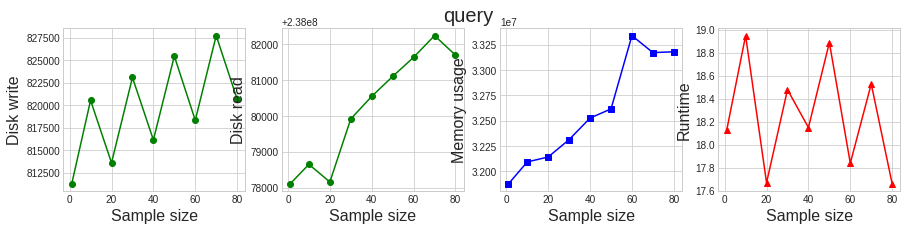

In [9]:
# Querying Plots
benchmark.multibench.plot_resources(multibench_results, sample_sizes, "query")